In [1]:
import pandas as pd
from transformers import Trainer, TrainingArguments

In [2]:
import json

def read_jsonl(filename):
  """Читает файл .jsonl и возвращает список JSON-объектов."""
  with open(filename, 'r') as f:
    data = []
    for line in f:
      data.append(json.loads(line.strip()))
  return data

# Пример использования:
data_test = read_jsonl("test.jsonl")
data_train = read_jsonl("train.jsonl")
data_val = read_jsonl("val.jsonl")

df_test = pd.DataFrame(data_test)
df_train = pd.DataFrame(data_train)
df_val = pd.DataFrame(data_val)

In [3]:
df_test

,premise,hypothesis,idx
0,"Гвардейцы подошли к грузовику, который как ока...",Гвардейцы подошли к сломанному грузовику.,0
1,"""К настоящему моменту число """"друзей"""" и подпи...",Березовский открывает аккаунты во всех соцсетях.,1
2,Ипотека в структуре их кредитных портфелей дос...,Треть их ипотеки составил кредитный портфель.,2
3,"""Вокруг все искусственно поудивлялись, натужно...",Весь предпремьерный период Барон Коэн использо...,3
4,"Учащийся политехнического техникума, находясь ...","Учащийся политеха напоил, избил и ограбил прох...",4
...,...,...,...
3193,"По мнению экспертов, большинство курильщиков н...",Эксперты сомневаются в способности курильщиков...,3193
3194,"Как рассказали в краевой полиции, еще летом пр...",Ради денег молодой человек регистрировал у себ...,3194
3195,Московскому институту теплотехники (МИТ) сейча...,Подольский электромеханический завод столкнулс...,3195
3196,"После мужчина убегал, а сумки вместе с содержи...",Мужчина выкидывал сумки и деньги.,3196


In [4]:
df_train

,premise,hypothesis,label,idx
0,"Женщину доставили в больницу, за ее жизнь сейч...",Женщину спасают врачи.,entailment,0
1,Он проводит невидимую грань между настоящим и ...,В эти минуты все мы подводим друг друга.,not_entailment,1
2,"Мужчина рассказал: детская коляска, принадлежа...",Сосед часто крадет детские коляски ради денег.,not_entailment,2
3,"Я просто об этом даже не думаю, потому что есл...",Спрятаться не удастся.,entailment,3
4,В ходе проверки нашли дома с наледью и сосульк...,Все сосульки с крыш были сбиты.,not_entailment,4
...,...,...,...,...
2611,Дом по адресу Ленина 63а является нежилым. Во...,Дом по адресу Ленина 63а подожгли.,not_entailment,2611
2612,"Он сообщил, что после митинга были задержаны, ...",Митинг продолжается.,not_entailment,2612
2613,"В результате трамваи в обе стороны встали, и ж...",Движение трамваев остановилось.,entailment,2613
2614,"Исследователи отмечают, что такое развитие сит...",Если ситуация будет развиваться в том же напра...,entailment,2614


In [5]:
!pip install transformers datasets bertviz -q

In [6]:
!pip install pyarrow==15.0.2

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch

from datasets import Dataset, DatasetDict
from torch.utils.data import DataLoader

from tqdm.auto import tqdm, trange
import numpy as np
from transformers import DataCollatorWithPadding

In [15]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "ai-forever/ruBert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/590 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.78M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/716M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruBert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
df_train

,premise,hypothesis,label,idx
0,"Женщину доставили в больницу, за ее жизнь сейч...",Женщину спасают врачи.,entailment,0
1,Он проводит невидимую грань между настоящим и ...,В эти минуты все мы подводим друг друга.,not_entailment,1
2,"Мужчина рассказал: детская коляска, принадлежа...",Сосед часто крадет детские коляски ради денег.,not_entailment,2
3,"Я просто об этом даже не думаю, потому что есл...",Спрятаться не удастся.,entailment,3
4,В ходе проверки нашли дома с наледью и сосульк...,Все сосульки с крыш были сбиты.,not_entailment,4
...,...,...,...,...
2611,Дом по адресу Ленина 63а является нежилым. Во...,Дом по адресу Ленина 63а подожгли.,not_entailment,2611
2612,"Он сообщил, что после митинга были задержаны, ...",Митинг продолжается.,not_entailment,2612
2613,"В результате трамваи в обе стороны встали, и ж...",Движение трамваев остановилось.,entailment,2613
2614,"Исследователи отмечают, что такое развитие сит...",Если ситуация будет развиваться в том же напра...,entailment,2614


In [9]:
df_train['label'] = df_train['label'].replace({'entailment': 1, 'not_entailment': 0})

In [10]:
df_val['label'] = df_val['label'].replace({'entailment': 1, 'not_entailment': 0})

In [11]:
train_dataset = Dataset.from_dict({'premise': df_train.premise, 'hypothesis': df_train.hypothesis, 'label': df_train.label})
val_dataset = Dataset.from_dict({'premise': df_val.premise, 'hypothesis': df_val.hypothesis, 'label': df_val.label})
test_dataset = Dataset.from_dict({'premise': df_test.premise, 'hypothesis': df_test.hypothesis})

In [12]:
dd = DatasetDict({"train": train_dataset, "val": val_dataset, "test": test_dataset})

In [13]:
dd

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 2616
    })
    val: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 307
    })
    test: Dataset({
        features: ['premise', 'hypothesis'],
        num_rows: 3198
    })
})

In [16]:
data_tokenized = dd.map(
    lambda x: tokenizer(x['premise'], x['hypothesis'],
                       padding="max_length",
                       truncation=True,
                       max_length=512),
    batched=True,
    remove_columns=['premise', 'hypothesis']
)

Map:   0%|          | 0/2616 [00:00<?, ? examples/s]

Map:   0%|          | 0/307 [00:00<?, ? examples/s]

Map:   0%|          | 0/3198 [00:00<?, ? examples/s]

In [17]:
collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [18]:
train_dataloader = DataLoader(data_tokenized['train'], shuffle=True, batch_size=4, collate_fn=collator)
val_dataloader = DataLoader(data_tokenized['val'], shuffle=False, batch_size=4, collate_fn=collator)

In [19]:
from torch.optim import Adam

if torch.cuda.is_available():
    model.cuda()

optimizer = Adam(model.parameters(), lr=1e-6)

In [20]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [21]:
losses = []
for epoch in trange(3):
    pbar = tqdm(train_dataloader)
    model.train()
    for i, batch in enumerate(pbar):
        out = model(**batch.to(model.device))
        out.loss.backward()
        if i % 1 == 0:
            optimizer.step()
            optimizer.zero_grad()
        losses.append(out.loss.item())
        pbar.set_description(f'loss: {np.mean(losses[-100:]):2.2f}')
    model.eval()
    eval_losses = []
    eval_preds = []
    eval_targets = []

    for batch in tqdm(val_dataloader):
        with torch.no_grad():
                out = model(**batch.to(model.device))
        eval_losses.append(out.loss.item())
        eval_preds.extend(out.logits.argmax(1).tolist())
        eval_targets.extend(batch['labels'].tolist())
    print('recent train loss', np.mean(losses[-100:]), 'eval loss', np.mean(eval_losses), 'accuracy', np.mean(np.array(eval_targets) == eval_preds))

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/654 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

recent train loss 0.683111235499382 eval loss 0.6827016317999208 accuracy 0.5570032573289903


  0%|          | 0/654 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

recent train loss 0.6868561190366745 eval loss 0.6778878097410326 accuracy 0.5700325732899023


  0%|          | 0/654 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

recent train loss 0.6658304989337921 eval loss 0.6697946403707776 accuracy 0.5700325732899023


## Проверка работы

In [22]:
def classify_rte(premise, hypothesis):
    # Токенизация
    encoded_input = tokenizer(premise, hypothesis, return_tensors="pt", truncation=True, padding=True)
    encoded_input = {key: tensor.to(model.device) for key, tensor in encoded_input.items()}

    # Передача в модель
    with torch.no_grad():
        outputs = model(**encoded_input)

    # Получение вероятностей
    probs = torch.softmax(outputs.logits, dim=1)

    # Класс с наибольшей вероятностью
    predicted_class = torch.argmax(probs).item()  # 0 - entailment, 1 - not_entailment

    return predicted_class, probs

In [23]:
# Пример использования
premise = "The man is eating a sandwich."
hypothesis = "The man is hungry."

predicted_class, probs = classify_rte(premise, hypothesis)

print(f"Predicted class: {predicted_class}")
print(f"Probabilities: {probs}")

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Predicted class: 1
Probabilities: tensor([[0.4996, 0.5004]], device='cuda:0')


In [24]:
labels = []
idx = []

for i in range(len(data_test)):
    premise = data_test[i]["premise"]
    hypothesis = data_test[i]["hypothesis"]

    # Классификация
    predicted_class, probs = classify_rte(premise, hypothesis)

    # Добавление метки в список
    labels.append(predicted_class)
    idx.append(data_test[i]["idx"])

In [25]:
df_answer = pd.DataFrame({"idx": idx, "label": labels})

In [26]:
df_answer['label'] = df_answer['label'].replace({1: 'entailment', 0: 'not_entailment'})

In [27]:
# Преобразование DataFrame в список словарей
data = df_answer.to_dict(orient="records")

# Создание файла JSONL
with open("TERRa.jsonl", "w") as f:
    for item in data:
        json.dump(item, f)
        f.write("\n")

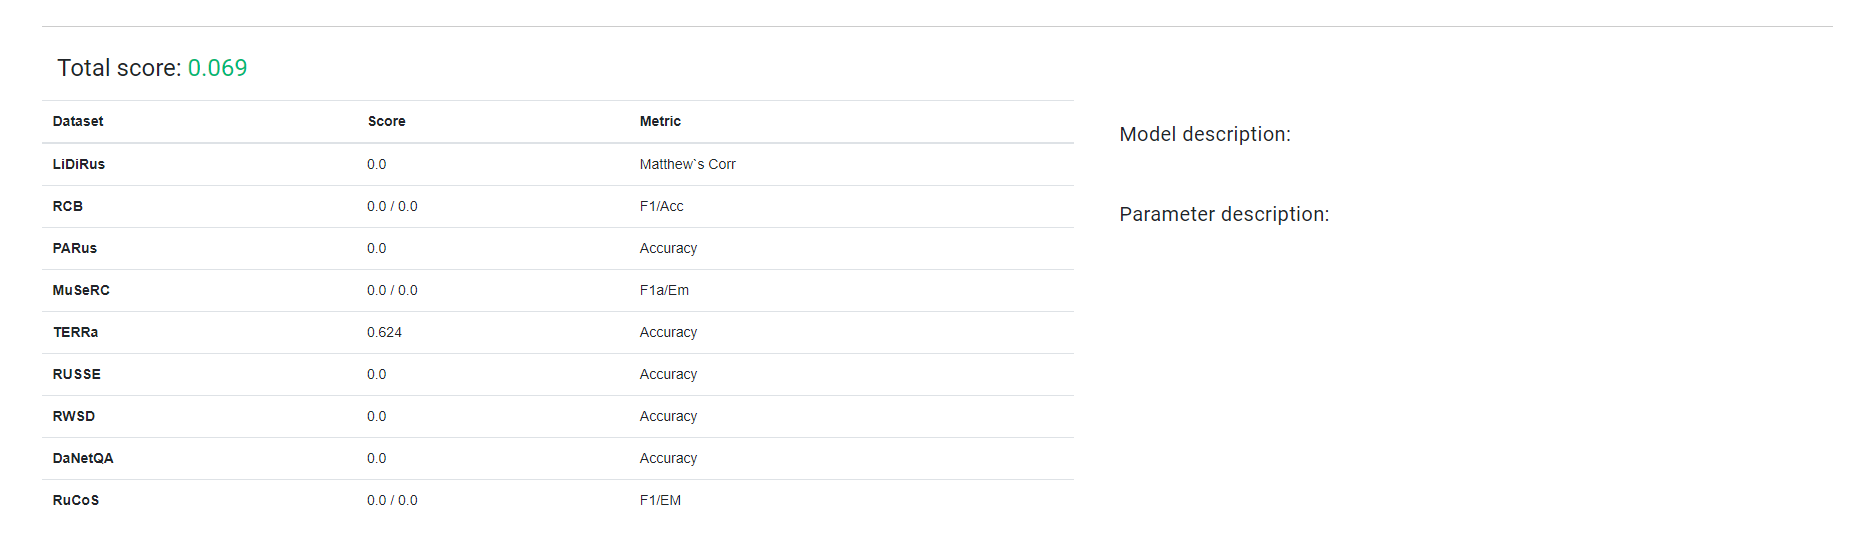



In [28]:
# Сохраняем модель и токенизатор
torch.save(model.state_dict(), "trained_model.pth")
tokenizer.save_pretrained("trained_tokenizer")

('trained_tokenizer/tokenizer_config.json',
 'trained_tokenizer/special_tokens_map.json',
 'trained_tokenizer/vocab.txt',
 'trained_tokenizer/added_tokens.json',
 'trained_tokenizer/tokenizer.json')

# Telegram

Ссылка на канал
https://t.me/Terrrrrrrrrrrrrrrrrraaaa_bot

In [29]:
# Загружаем модель
model2 = AutoModelForSequenceClassification.from_pretrained("ai-forever/ruBert-base") # Используем базовую модель BERT
model2.load_state_dict(torch.load("trained_model.pth"))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruBert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-29-2c1107870605>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We

<All keys matched successfully>

In [31]:
!pip install telebot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 16.2 MB/s eta 0:00:00


In [34]:
import telebot
bot = telebot.TeleBot("7528310537:AAFOlTTsU7xSQtCgWkXS02Jd-EiNBRlv_tE")

@bot.message_handler(commands=['start'])
def start(message):
    bot.send_message(message.chat.id, "Введите 'premise':")
    bot.register_next_step_handler(message, get_premise)

def get_premise(message):
    global premise
    premise = message.text
    print(premise)
    bot.send_message(message.chat.id, "Введите 'hypothesis':")
    bot.register_next_step_handler(message, get_hypothesis)

def get_hypothesis(message):
    global hypoth
    hypoth = message.text
    print(hypoth)

    predicted_class, probs = classify_rte(premise, hypothesis)

    print(f"Predicted class: {predicted_class}")
    print(f"Probabilities: {probs}")

    answers = {1: 'entailment', 0: 'not_entailment'}

    bot.send_message(message.chat.id, f"Ответ {answers[predicted_class]}")

bot.polling()

The man is eating a sandwich
The man is hungry.
Predicted class: 0
Probabilities: tensor([[0.5715, 0.4285]], device='cuda:0')
